# Harris County Home Price Estimations

In [1]:
import sqlite3

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Building and Real Account Data
This has the base features to include for the model. In this file I am only pulling the continuous data. So using the date built, improvement square feet, gross area, base area, land area, perimeter and size index to estimate the assessed_val.

In [2]:
con = sqlite3.connect('HouseProtestValues.db')
sql_query = '''SELECT  br.acct,
                       br.bld_num,
                       br.date_erected,
                       br.im_sq_ft,
                       br.gross_ar,
                       br.base_ar,
                       ra.land_ar,
                       br.perimeter,
                       br.size_index,
                       ra.land_val,
                       ra.bld_val,
                       ra.assessed_val,
                       ra.tot_appr_val,
                       ra.tot_mkt_val
            FROM building_res as br
            LEFT JOIN real_acct as ra ON br.acct = ra.acct
            WHERE br.impr_tp = 1001 AND br.property_use_cd = 'A1' AND br.date_erected > 10;'''

base_df = pd.read_sql_query(sql_query, con)

## Fixtures Data
This has features such as, number of rooms such as bedrooms (RMB), full bath (RMF), half bath (RMH) and total rooms (RMT). This will be merged in a pandas dataframe based on the account number and building number. This data was storred in a table format with multiple accounts and building numbers for each feature, so I created a pivot table with the features as columns.

In [3]:
# Story Height Index: STY
# Room: Bedroom: RMB
# Room: Full Bath: RMF
# Room: Half Bath: RMH
# Room: Total: RMT
fixtures_sql = """SELECT *
                  FROM "fixtures"
                  WHERE type IN ('STY', 'RMB','RMF','RMH','RMT')
                """
fixtures = pd.read_sql_query(fixtures_sql, con)

# Pivot table
fix_pt = fixtures.pivot_table(index=['acct', 'bld_num'], columns='type', values='units', aggfunc='sum')
fix_pt = fix_pt.reset_index()
fix_pt.fillna(0, inplace=True)

## Merge Base Data with Fixtures Pivot table

In [4]:
data_df = pd.merge(base_df, fix_pt, on=['acct', 'bld_num'], how='left')
data_df.dropna(inplace=True)

In [5]:
print(data_df.info())
print(f"Columns: {data_df.shape[1]} | Rows: {data_df.shape[0]}")

<class 'pandas.core.frame.DataFrame'>
Index: 1121460 entries, 0 to 1122305
Data columns (total 19 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   acct          1121460 non-null  int64  
 1   bld_num       1121460 non-null  int64  
 2   date_erected  1121460 non-null  int64  
 3   im_sq_ft      1121460 non-null  int64  
 4   gross_ar      1121460 non-null  int64  
 5   base_ar       1121460 non-null  int64  
 6   land_ar       1121460 non-null  int64  
 7   perimeter     1121460 non-null  int64  
 8   size_index    1121460 non-null  float64
 9   land_val      1121460 non-null  float64
 10  bld_val       1121460 non-null  float64
 11  assessed_val  1121460 non-null  float64
 12  tot_appr_val  1121460 non-null  float64
 13  tot_mkt_val   1121460 non-null  float64
 14  RMB           1121460 non-null  float64
 15  RMF           1121460 non-null  float64
 16  RMH           1121460 non-null  float64
 17  RMT           1121460 non-null  

## Sample the data_df
There are over 1 million different residential houses that have data and that is too many to run the whole set on the model so we will pull a random sub set of the houses to create a model for the rest. 

In [6]:
sample_df = data_df.sample(n=1000, random_state=42)

x = sample_df[['date_erected', 'im_sq_ft',
               'gross_ar', 'base_ar', 'land_ar', 'perimeter', 'size_index',
               'RMB', 'RMF', 'RMH', 'RMT', 'STY']]
y = sample_df['assessed_val']

In [7]:
print(f"All Data{sample_df.shape} | x {x.shape} | y {y.shape}")

All Data(1000, 19) | x (1000, 12) | y (1000,)


In [8]:
# Free up memory
base_df = None
fix_pt = None
fixtures = None

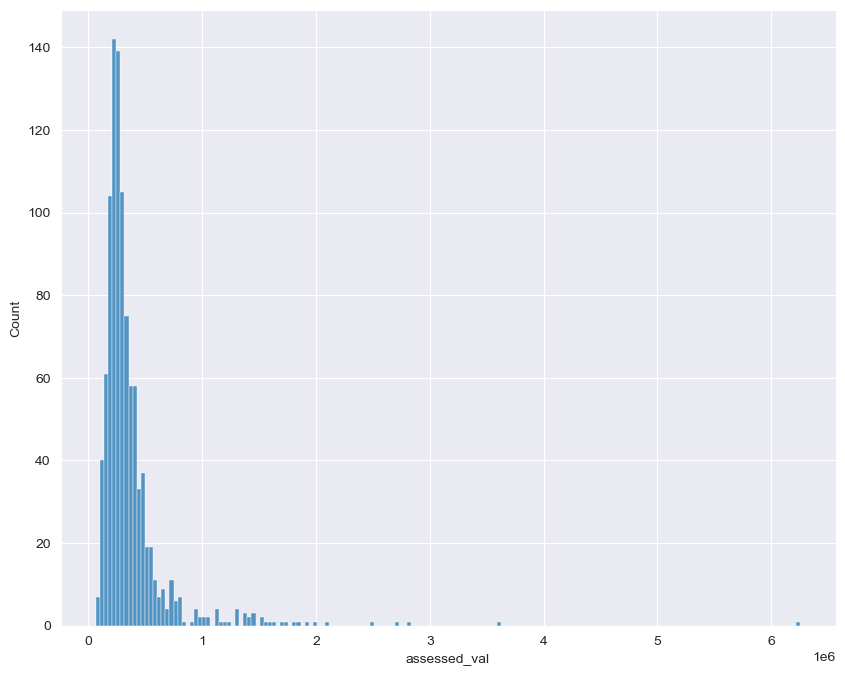

In [9]:
plt.figure(figsize=(10, 8))
sns.histplot(data=sample_df, x="assessed_val")
plt.show()

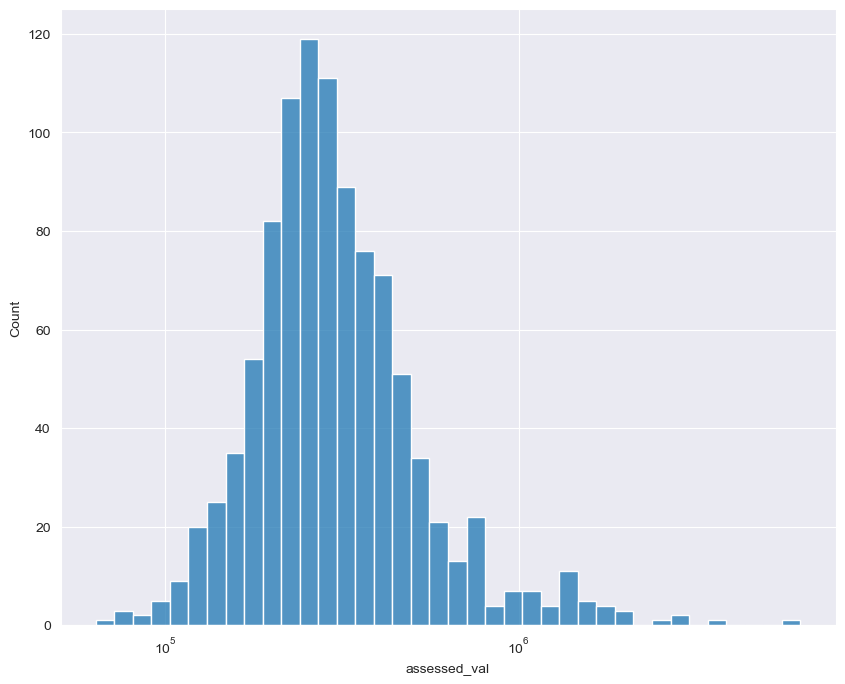

In [10]:
plt.figure(figsize=(10, 8))
sns.histplot(data=sample_df, x="assessed_val", log_scale=True)
plt.show()

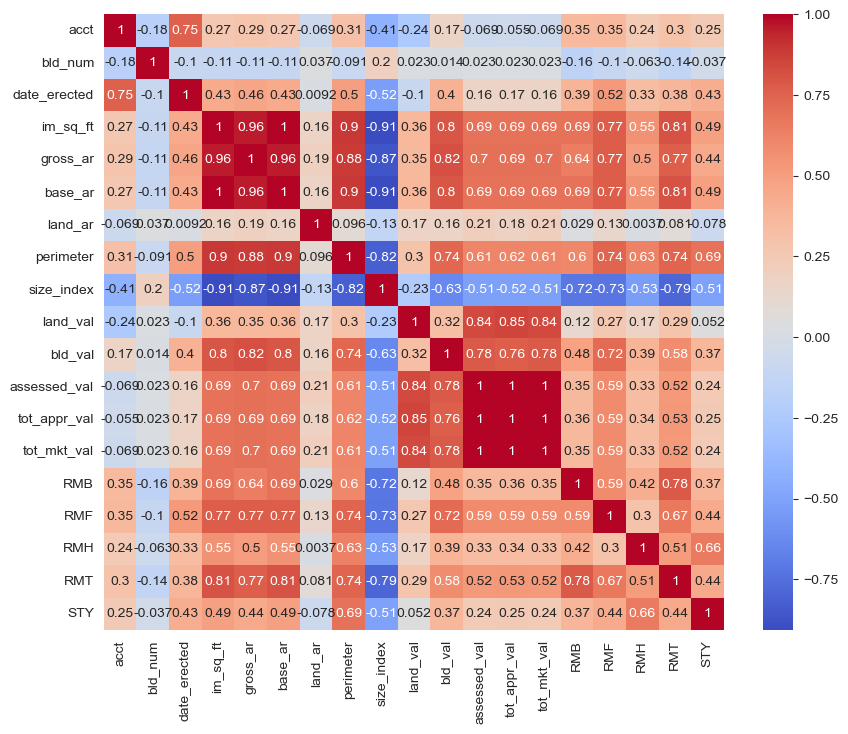

In [11]:
corr_matrix = sample_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(data=corr_matrix, annot=True, cmap='coolwarm')
plt.show()

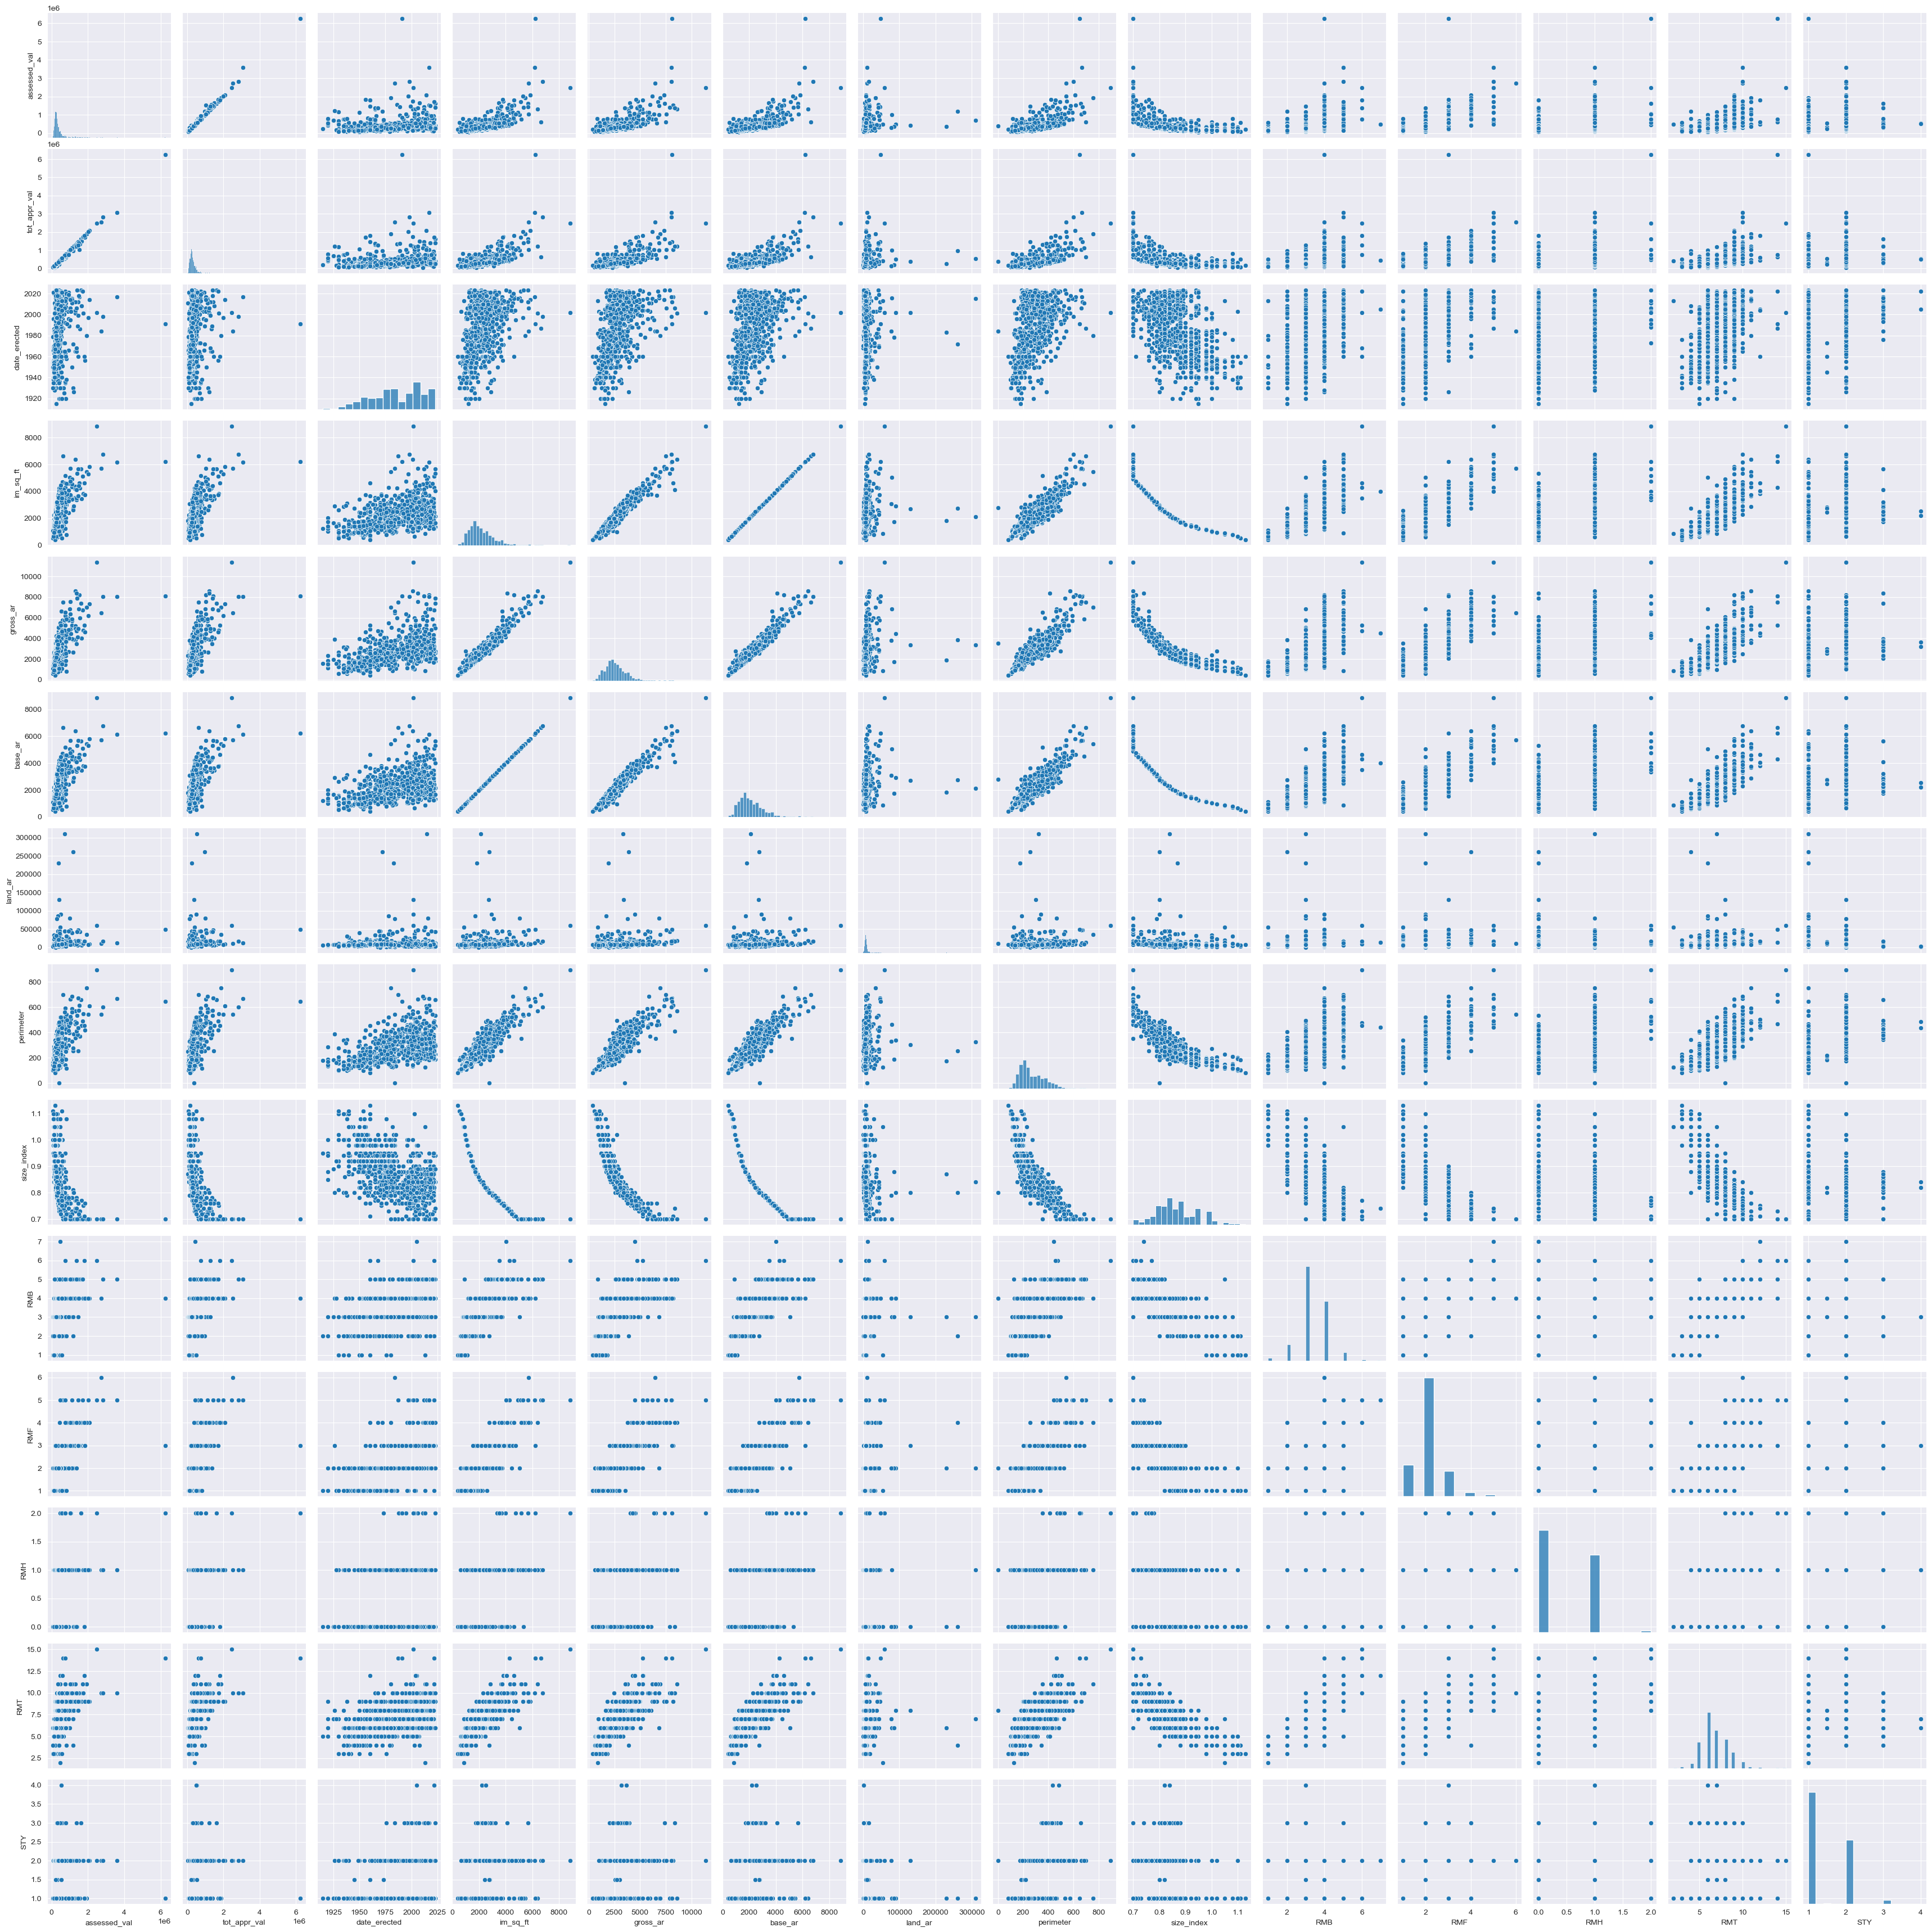

In [12]:
sns.pairplot(data=sample_df, vars=['assessed_val', 'tot_appr_val', 'date_erected', 'im_sq_ft',
                                   'gross_ar', 'base_ar', 'land_ar', 'perimeter', 'size_index',
                                   'RMB', 'RMF', 'RMH', 'RMT', 'STY'])

## Train, Test, Split!
The training and testing sets get split, but I will need to see some examples to see if there are indexes on the y's

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [14]:
etc = ExtraTreesRegressor(random_state=42)

In [15]:
etc.fit(x_train, y_train)

ExtraTreesRegressor(random_state=42)

In [16]:
cross_val_score(etc, x_train, y_train, cv=5, n_jobs=4).mean()

0.22586667852338876

In [17]:
param_grid = {
    'n_estimators': [100, 500, 700, 750, 800],
    'min_samples_leaf': [0.25, 0.5, 1, 2, 3, 4],
    'max_features': [2, 3, 4, 5, 7, 10],
    'criterion': ['absolute_error']
}

In [18]:
etc2 = GridSearchCV(etc, param_grid, cv=5, n_jobs=4, scoring='neg_mean_squared_error')

In [19]:
etc2.fit(x_train, y_train)

GridSearchCV(cv=4, estimator=ExtraTreesRegressor(random_state=42), n_jobs=4,
             param_grid={'criterion': ['absolute_error'],
                         'max_features': [2, 3, 4, 5, 7, 10],
                         'min_samples_leaf': [0.25, 0.5, 1, 2, 3, 4],
                         'n_estimators': [100, 500, 700, 750, 800]},
             scoring='neg_mean_squared_error')

In [20]:
etc2.best_params_

{'criterion': 'absolute_error',
 'max_features': 5,
 'min_samples_leaf': 3,
 'n_estimators': 100}

In [21]:
etc2.best_score_

-61739034596.38144

In [22]:
y_pred = etc2.predict(x_test)

In [23]:
r2_score(y_test, y_pred)

0.6671774304209059

# Residual Analysis

In [24]:
actual = y_test.to_list()
predicted = etc2.predict(x_test)

act_pred_df = pd.DataFrame({'actual': actual, "predicted": predicted, })
act_pred_df['residuals'] = act_pred_df['actual'] - act_pred_df['predicted']
act_pred_df

,actual,predicted,residuals
0,311778.0,356543.780,-44765.780
1,305767.0,301189.545,4577.455
2,240020.0,352339.415,-112319.415
3,275861.0,289902.365,-14041.365
4,1922693.0,1592028.770,330664.230
...,...,...,...
195,291682.0,292624.985,-942.985
196,120017.0,255957.715,-135940.715
197,1316400.0,597283.670,719116.330
198,378714.0,251066.010,127647.990


<Axes: xlabel='actual', ylabel='predicted'>

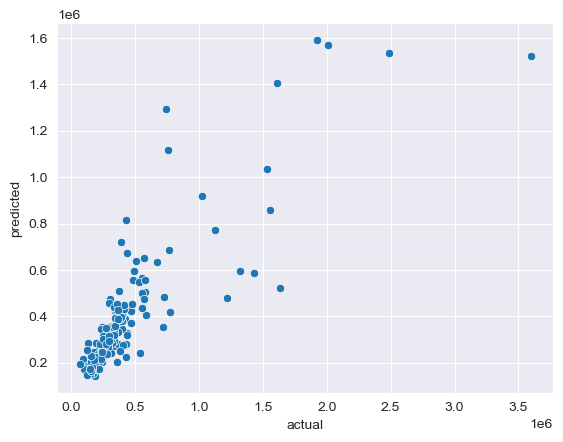

In [34]:
sns.scatterplot(data=act_pred_df, x='actual', y='predicted')

<Axes: xlabel='actual', ylabel='residuals'>

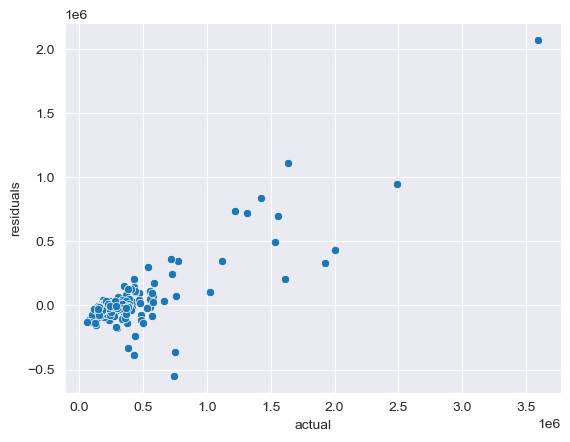

In [30]:
sns.scatterplot(data=act_pred_df, x='actual', y='residuals')